In [1]:
# imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats

# Problem 2

## Q1

In [28]:
# generate graph
degree_dist = scipy.stats.powerlaw.rvs(a=(1/3), loc = 0, scale = 100, size = 1000)
degree_dist = [round(n)+1 for n in degree_dist]
if np.sum(degree_dist) % 2 != 0:
    degree_dist[0] += 1
G = nx.configuration_model(degree_dist, create_using=nx.Graph())
degree_freq = nx.degree_histogram(G)

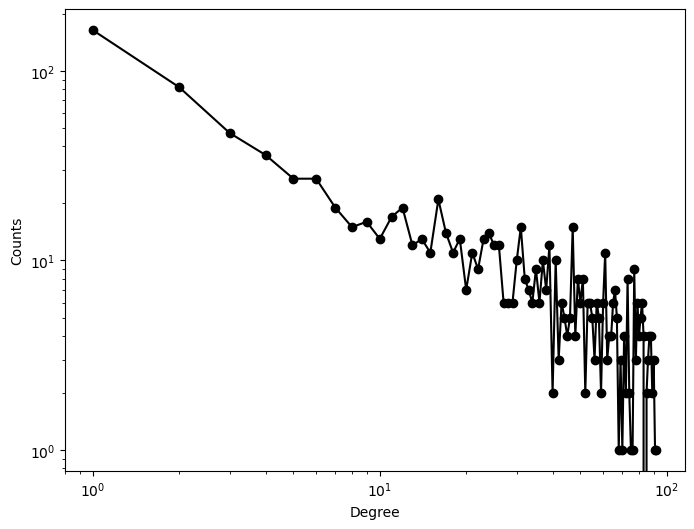

In [29]:
degrees = range(len(degree_freq))
plt.figure(figsize=(8, 6))
plt.loglog(degrees[1:], degree_freq[1:],'ko-')
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.show()

In [24]:
# Parameters of the model
beta = 0.0025 #transmission rate
alpha = 0.01 #recovery rate

I0 = 0.01 #initial fraction of infected nodes
S0 = 1.0 - I0

# Initial conditions
G_deg_sum = [a * b for a, b in zip(degree_freq, range(0, len(degree_freq)))]
total_degree = sum(G_deg_sum)
avg_k = sum(G_deg_sum) / G.number_of_nodes()
print(avg_k)
Sk = np.zeros((len(degree_freq))) #array for expected S_k
Ik = np.zeros((len(degree_freq))) #array for expected I_k

for k in range(len(degree_freq)):
  #set an expectation of I0 fraction of nodes of degree k infectious
  Sk[k] = degree_freq[k]*S0
  Ik[k] = degree_freq[k]*I0


23.23


In [22]:
# Run the model

# Discrete steps of Euler's methods
res = [] #list of results
history = []
S = S0; I = I0; #set initial conditions
h = 0.1; #timestep
T = np.arange(1,500/h)
for t in T:

  # Calculate the mean-field
  theta = 0.0
  for k in range(len(degree_freq)):
    theta += k*Ik[k]/total_degree
  history.append(theta)

  # Set initial global quantities
  S = 0.0
  I = 0.0

  # Run Euler's method for all degree classes k
  for k in range(len(degree_freq)):
    # calculate speeds
    delta_Sk = -beta*k*theta*Sk[k] + alpha*Ik[k]
    delta_Ik = beta*k*theta*Sk[k]  - alpha*Ik[k]
    # update dynamical variables
    Sk[k] += delta_Sk*h #Ik(t+h)
    Ik[k] += delta_Ik*h #Ik(t+h)
    # update global quantities
    S += Sk[k]
    I += Ik[k]
  res.append((S/G.number_of_nodes(),I/G.number_of_nodes()))

#zip unpacked list of tuples (n-th elements all together)
#map them to arrays
St,It = map(np.array, zip(*res))

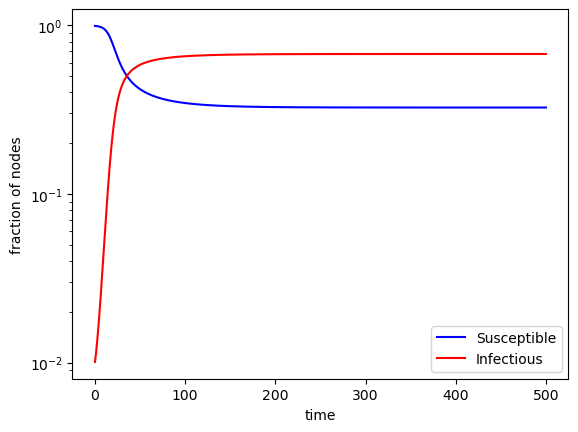

In [25]:
#plot results
fig,ax = plt.subplots()
ax.plot(h*T, St, 'b', label='Susceptible')
ax.plot(h*T,It, 'r', label='Infectious')
ax.legend()
ax.set(yscale='log')
ax.set_xlabel("time")
ax.set_ylabel("fraction of nodes")
plt.show()

## Q2 - Vaccinated Nodes

In [36]:
# Parameters of the model
beta = 0.005 #transmission rate
alpha = 0.015 #recovery rate
rho = 0.1
vax = 0.4

I0 = 0.01 #initial fraction of infected nodes
Iv0 = I0 * vax # initial fraction of vaccinated infected nodes
S0 = 1.0 - I0
Sv0 = S0 * vax # initial fraction of vaccinated susceptible nodes
print(Sv0+Iv0)

# normalize
n_sum = I0 + Iv0 + S0 + Sv0
I0 /= n_sum
Iv0 /= n_sum
S0 /= n_sum
Sv0 /= n_sum

# Initial conditions
G_deg_sum = [a * b for a, b in zip(degree_freq, range(0, len(degree_freq)))]
total_degree = np.sum(G_deg_sum)
avg_k = np.sum(G_deg_sum) / G.number_of_nodes()
print(avg_k)
Sk = np.zeros((len(degree_freq))) #array for expected S_k
Ik = np.zeros((len(degree_freq))) #array for expected I_k
Svk = np.zeros((len(degree_freq))) #array for expected S^v_k
Ivk = np.zeros((len(degree_freq))) #array for expected I^v_k

for k in range(len(degree_freq)):
  #set an expectation of I0 fraction of nodes of degree k infectious
  Sk[k] = degree_freq[k]*S0
  Ik[k] = degree_freq[k]*I0
  Svk[k] = degree_freq[k]*Sv0
  Ivk[k] = degree_freq[k]*Iv0


0.4
23.502


In [37]:
# Run the model

# Discrete steps of Euler's methods
res = [] #list of results
history = []
S = S0; I = I0; Sv = Sv0; Iv = Iv0; #set initial conditions
h = 0.1; #timestep
T = np.arange(1,500/h)
for t in T:

  # Calculate the mean-field
  theta = 0.0
  theta_v = 0.0
  for k in range(len(degree_freq)):
    theta += k*Ik[k]/total_degree
    theta_v += k*Ivk[k]/total_degree
  history.append(theta+theta_v)

  # Set initial global quantities
  S = 0.0
  I = 0.0
  Sv = 0.0
  Iv = 0.0

  # Run Euler's method for all degree classes k
  for k in range(len(degree_freq)):
    # calculate speeds
    delta_Sk = -beta*k*theta*Sk[k] + alpha*Ik[k] - (1-rho)*beta*k*theta_v*Sk[k]
    delta_Ik = beta*k*theta*Sk[k]  - alpha*Ik[k] + (1-rho)*beta*k*theta_v*Sk[k]
    delta_Svk = -(1-rho)*beta*k*theta*Svk[k] + alpha*Ivk[k] - (1-rho)*beta*k*theta_v*Svk[k]
    delta_Ivk = (1-rho)*beta*k*theta*Svk[k]  - alpha*Ivk[k] + (1-rho)*beta*k*theta_v*Svk[k]
    # update dynamical variables
    Sk[k] += delta_Sk*h #Ik(t+h)
    Ik[k] += delta_Ik*h #Ik(t+h)
    Svk[k] += delta_Svk*h #Ik(t+h)
    Ivk[k] += delta_Ivk*h #Ik(t+h)
    # update global quantities
    S += Sk[k]
    I += Ik[k]
    Sv += Svk[k]
    Iv += Ivk[k]
  res.append(((S+Sv)/G.number_of_nodes(),(I+Iv)/G.number_of_nodes()))

#zip unpacked list of tuples (n-th elements all together)
#map them to arrays
St,It = map(np.array, zip(*res))

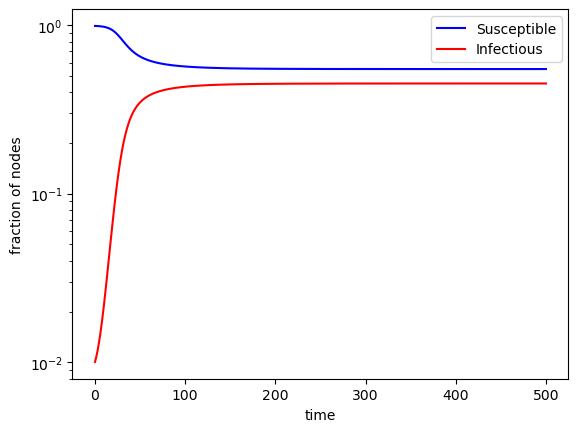

In [38]:
#plot results
fig,ax = plt.subplots()
ax.plot(h*T, St, 'b', label='Susceptible')
ax.plot(h*T,It, 'r', label='Infectious')
ax.legend()
ax.set(yscale='log')
ax.set_xlabel("time")
ax.set_ylabel("fraction of nodes")
plt.show()

## Q3 - Given Params

In [39]:
# generate graph
degree_dist = np.random.geometric((1/4), 1000)
degree_dist = [round(n) for n in degree_dist]
if np.sum(degree_dist) % 2 != 0:
    degree_dist[0] += 1
G = nx.configuration_model(degree_dist)
degree_freq = nx.degree_histogram(G)

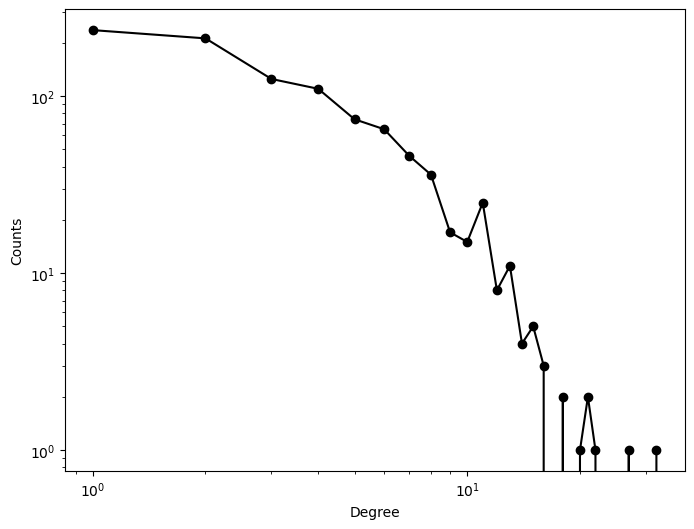

In [40]:
degrees = range(len(degree_freq))
plt.figure(figsize=(8, 6))
plt.loglog(degrees[1:], degree_freq[1:],'ko-')
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.show()

In [109]:
# Parameters of the model
beta = 0.3 #transmission rate
alpha = 1 #recovery rate
rho = 1
vax = 0.4

I0 = 0.01 #initial fraction of infected nodes
Iv0 = I0 * vax # initial fraction of vaccinated infected nodes
S0 = 1.0 - I0
Sv0 = S0 * vax # initial fraction of vaccinated susceptible nodes

# normalize
n_sum = I0 + Iv0 + S0 + Sv0
I0 /= n_sum
Iv0 /= n_sum
S0 /= n_sum
Sv0 /= n_sum

# Initial conditions
G_deg_sum = [a * b for a, b in zip(degree_freq, range(0, len(degree_freq)))]
total_degree = np.sum(G_deg_sum)
avg_k = np.sum(G_deg_sum) / G.number_of_nodes()
print(avg_k)
Sk = np.zeros((len(degree_freq))) #array for expected S_k
Ik = np.zeros((len(degree_freq))) #array for expected I_k
Svk = np.zeros((len(degree_freq))) #array for expected S^v_k
Ivk = np.zeros((len(degree_freq))) #array for expected I^v_k

for k in range(len(degree_freq)):
  #set an expectation of I0 fraction of nodes of degree k infectious
  Sk[k] = degree_freq[k]*S0
  Ik[k] = degree_freq[k]*I0
  Svk[k] = degree_freq[k]*Sv0
  Ivk[k] = degree_freq[k]*Iv0


3.868


In [110]:
# Run the model

# Discrete steps of Euler's methods
res = [] #list of results
history = []
S = S0; I = I0; Sv = Sv0; Iv = Iv0; #set initial conditions
h = 0.1; #timestep
T = np.arange(1,500/h)
for t in T:

  # Calculate the mean-field
  theta = 0.0
  theta_v = 0.0
  for k in range(len(degree_freq)):
    theta += k*Ik[k]/total_degree
    theta_v += k*Ivk[k]/total_degree
  history.append(theta+theta_v)

  # Set initial global quantities
  S = 0.0
  I = 0.0
  Sv = 0.0
  Iv = 0.0

  # Run Euler's method for all degree classes k
  for k in range(len(degree_freq)):
    # calculate speeds
    delta_Sk = -beta*k*theta*Sk[k] + alpha*Ik[k] - (1-rho)*beta*k*theta_v*Sk[k]
    delta_Ik = beta*k*theta*Sk[k]  - alpha*Ik[k] + (1-rho)*beta*k*theta_v*Sk[k]
    delta_Svk = -(1-rho)*beta*k*theta*Svk[k] + alpha*Ivk[k] - (1-rho)*beta*k*theta_v*Svk[k]
    delta_Ivk = (1-rho)*beta*k*theta*Svk[k]  - alpha*Ivk[k] + (1-rho)*beta*k*theta_v*Svk[k]
    # update dynamical variables
    Sk[k] += delta_Sk*h
    Ik[k] += delta_Ik*h
    Svk[k] += delta_Svk*h
    Ivk[k] += delta_Ivk*h
    # update global quantities
    S += Sk[k]
    I += Ik[k]
    Sv += Svk[k]
    Iv += Ivk[k]
  res.append(((S+Sv)/G.number_of_nodes(),(I+Iv)/G.number_of_nodes()))

#zip unpacked list of tuples (n-th elements all together)
#map them to arrays
St,It = map(np.array, zip(*res))

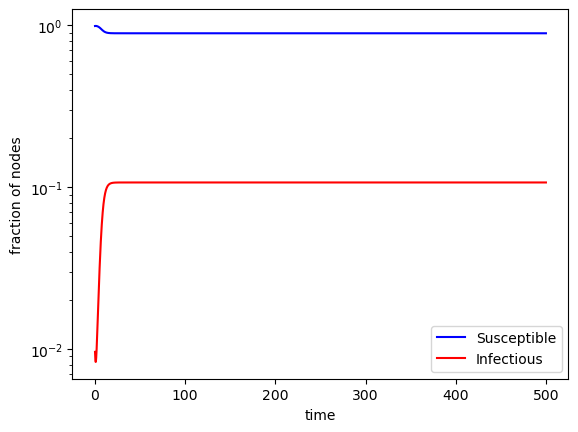

In [111]:
#plot results
fig,ax = plt.subplots()
ax.plot(h*T, St, 'b', label='Susceptible')
ax.plot(h*T,It, 'r', label='Infectious')
ax.legend()
ax.set(yscale='log')
ax.set_xlabel("time")
ax.set_ylabel("fraction of nodes")
plt.show()

# Q4 - High Degree Vax

In [118]:
# generate graph
degree_dist = np.random.geometric((1/4), 1000)
degree_dist = [round(n) for n in degree_dist]
if np.sum(degree_dist) % 2 != 0:
    degree_dist[0] += 1
G = nx.configuration_model(degree_dist)
degree_freq = nx.degree_histogram(G)

In [119]:
# get the 40% of nodes with the highest degree

# find the index where the nodes with the highest degree start
sum = 0
index_40 = 0
while sum < 400:
    sum += degree_freq.pop()
    index_40 += 1

degree_freq = nx.degree_histogram(G)
degree_freq_unvax = degree_freq[:-(index_40+1)]
degree_freq_vax = degree_freq[-(index_40+1):]

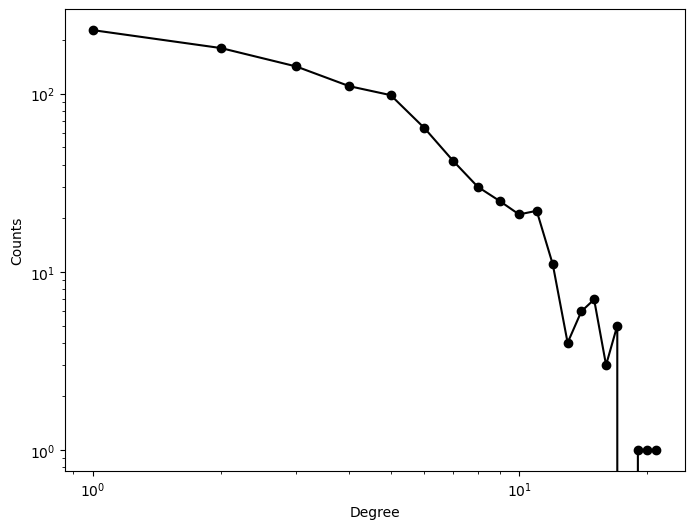

In [120]:
degrees = range(len(degree_freq))
plt.figure(figsize=(8, 6))
plt.loglog(degrees[1:], degree_freq[1:],'ko-')
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.show()

In [121]:
# Parameters of the model
beta = 0.3 #transmission rate
alpha = 1 #recovery rate
rho = 0.53
vax = 0.4

I0 = 0.01 #initial fraction of infected nodes
S0 = 1.0 - I0
Iv0 = I0 * vax # initial fraction of vaccinated infected nodes
Sv0 = S0 * vax # initial fraction of vaccinated susceptible nodes

# Initial conditions
G_deg_sum = [a * b for a, b in zip(degree_freq, range(0, len(degree_freq)))]
total_degree = np.sum(G_deg_sum)
avg_k = np.sum(G_deg_sum) / G.number_of_nodes()
print(avg_k)
Sk = np.zeros((len(degree_freq_unvax))) #array for expected S_k
Ik = np.zeros((len(degree_freq_unvax))) #array for expected I_k
Svk = np.zeros((len(degree_freq_vax))) #array for expected S^v_k
Ivk = np.zeros((len(degree_freq_vax))) #array for expected I^v_k

for k in range(len(degree_freq_unvax)):
  #set an expectation of I0 fraction of nodes of degree k infectious
  Sk[k] = degree_freq_unvax[k]*S0
  Ik[k] = degree_freq_unvax[k]*I0

for k in range(len(degree_freq_vax)):
  #set an expectation of I0 fraction of nodes of degree k infectious
  Svk[k] = degree_freq_vax[k]*S0
  Ivk[k] = degree_freq_vax[k]*I0

# normalize
n_sum = I0 + Iv0 + S0 + Sv0
I0 /= n_sum
Iv0 /= n_sum
S0 /= n_sum
Sv0 /= n_sum


4.104


In [122]:
# Run the model

# Discrete steps of Euler's methods
res = [] #list of results
history = []
S = S0; I = I0; Sv = Sv0; Iv = Iv0; #set initial conditions
h = 0.1; #timestep
T = np.arange(1,500/h)
for t in T:

  # Calculate the mean-field
  theta = 0.0
  theta_v = 0.0
  for k in range(len(degree_freq_unvax)):
    theta += k*(Ik[k])/total_degree
  for k in range(len(degree_freq_vax)):
    theta_v += (k+len(degree_freq_unvax))*(Ivk[k])/total_degree
  history.append(theta)

  # Set initial global quantities
  S = 0.0
  I = 0.0
  Sv = 0.0
  Iv = 0.0
  
  # Run Euler's method for all degree classes k
  for k in range(len(degree_freq_unvax)):
    # calculate speeds
    delta_Sk = -beta*k*theta*Sk[k] + alpha*Ik[k] - (1-rho)*beta*k*theta_v*Sk[k]
    delta_Ik = beta*k*theta*Sk[k]  - alpha*Ik[k] + (1-rho)*beta*k*theta_v*Sk[k]
    
    # update dynamical variables
    Sk[k] += delta_Sk*h
    Ik[k] += delta_Ik*h
    
    # update global quantities
    S += Sk[k]
    I += Ik[k]
    
  for k in range(len(degree_freq_vax)):
    # calculate speeds
    delta_Svk = -(1-rho)*beta*(k+len(degree_freq_unvax))*theta*Svk[k] + alpha*Ivk[k] - (1-rho)*beta*(k+len(degree_freq_unvax))*theta_v*Svk[k]
    delta_Ivk = (1-rho)*beta*(k+len(degree_freq_unvax))*theta*Svk[k]  - alpha*Ivk[k] + (1-rho)*beta*(k+len(degree_freq_unvax))*theta_v*Svk[k]

    # update dynamical variables
    Svk[k] += delta_Svk*h
    Ivk[k] += delta_Ivk*h

    # update global quantities
    Sv += Svk[k]
    Iv += Ivk[k]
  res.append(((S+Sv)/G.number_of_nodes(),(I+Iv)/G.number_of_nodes()))

#zip unpacked list of tuples (n-th elements all together)
#map them to arrays
St,It = map(np.array, zip(*res))

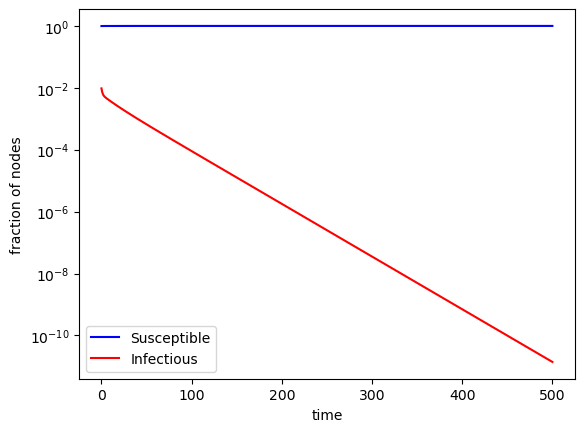

In [123]:
#plot results
fig,ax = plt.subplots()
ax.plot(h*T, St, 'b', label='Susceptible')
ax.plot(h*T, It, 'r', label='Infectious')
ax.legend()
ax.set(yscale='log')
ax.set_xlabel("time")
ax.set_ylabel("fraction of nodes")
plt.show()